In [35]:
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [36]:
df_raw = sns.load_dataset("flights")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [37]:
df_raw.sample(10,random_state=2025)

,year,month,passengers
2,1949,Mar,132
82,1955,Nov,237
77,1955,Jun,315
26,1951,Mar,178
23,1950,Dec,140
44,1952,Sep,209
54,1953,Jul,264
0,1949,Jan,112
5,1949,Jun,135
108,1958,Jan,340


In [38]:
df_baking = df_raw.copy()
df_baking['month'] = pd.to_datetime(df_baking['month'], format='%b').dt.month
df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day=1))
df_baking = df_baking.set_index('date')
df_baking = df_baking.drop(columns=['year','month'])
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [39]:
df_train = df.iloc[:-12,:]
df_test = df.iloc[-12:,:]
df_train

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


In [40]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
passengers,132.0,262.492424,106.625799,104.0,176.5,239.5,343.25,559.0


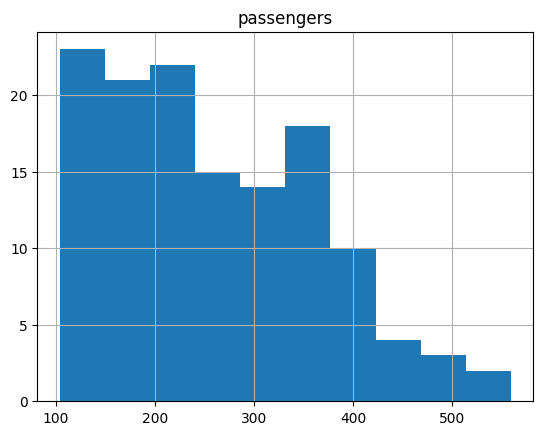

In [41]:
df_train.hist()
plt.show()

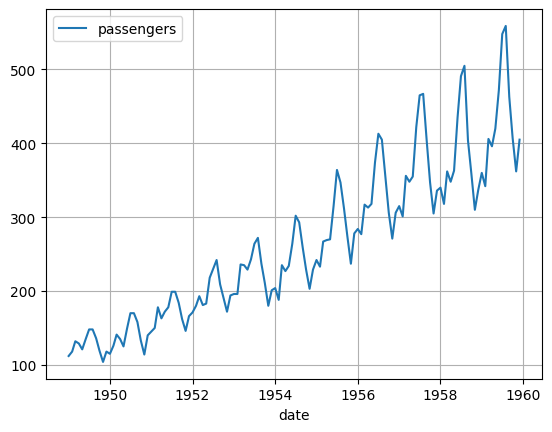

In [42]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

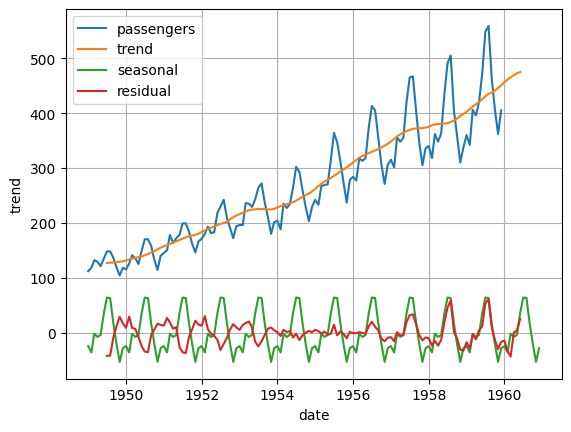

In [43]:
decomposition = seasonal_decompose(df['passengers'],period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(df_train)
sns.lineplot(trend,label='trend')
sns.lineplot(seasonal,label='seasonal')
sns.lineplot(residual,label='residual')
plt.grid(True)
plt.show()




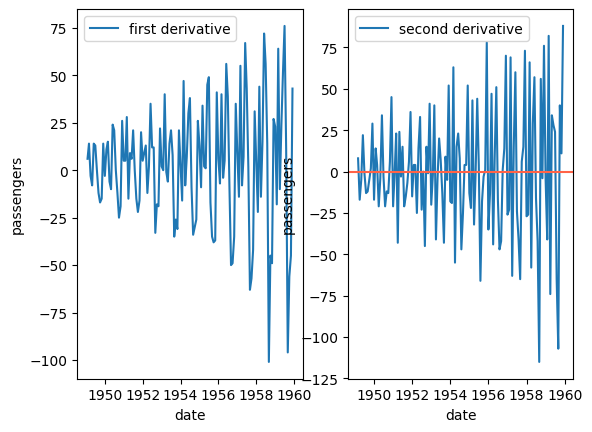

In [44]:
# d = stationarity, data points have no trend
fig,ax=plt.subplots(1,2)
sns.lineplot(df_train['passengers'].diff(),label='first derivative',ax=ax[0])
sns.lineplot(df_train['passengers'].diff().diff(),label='second derivative',ax=ax[1])
plt.axhline(0,color='tomato')
plt.show()

In [45]:
# alpha = 0.05 if the p value is above alpha then we can say that it is not stationary (it has trend)
# if p value < alpha then we can rule out that it is stationary  (it has no trend)
ad_fuller = adfuller(df_train)
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: 0.89
adf P Value: 0.99


In [46]:
ad_fuller = adfuller(df_train['passengers'].diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -2.40
adf P Value: 0.14


In [47]:
ad_fuller = adfuller(df_train['passengers'].diff().diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -14.25
adf P Value: 0.00


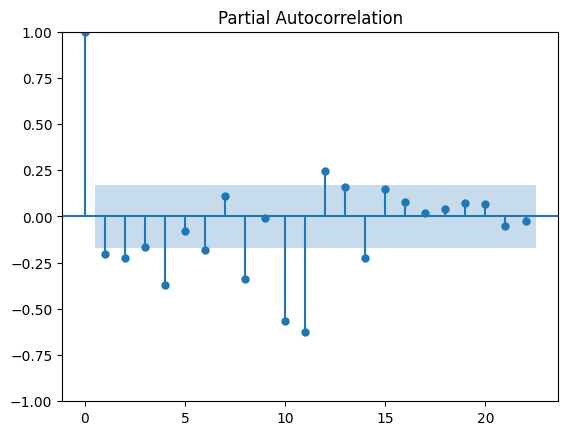

In [48]:
# value p is the autoregressive term - autoregressive = seasonality
plot_pacf(df_train.diff().diff().dropna())
plt.show()

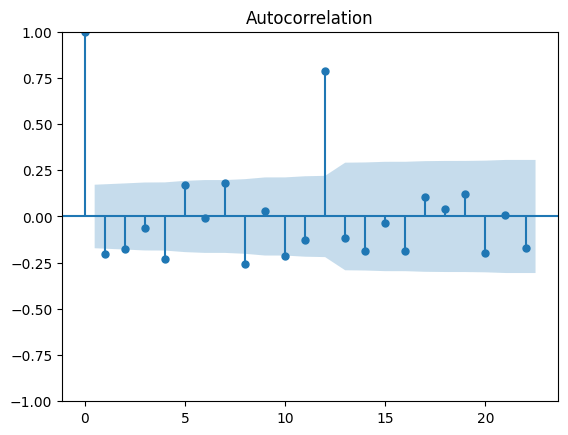

In [49]:
# q is the moving average
plot_acf(df_train.diff().diff().dropna())
plt.show()

In [ ]:
arima = ARIMA(df['passengers'],order=(2,1,2)) # order variables above 'd' (differencing),'p' (partial autocorrelation), 'q' (moving average) the goal in setting these is to make the P>|z| to be the lowest possible. find the lowest AIC or P>|z| for highest precision
ts_arima = arima.fit()
print(ts_arima.summary())

/workspaces/4Geeks_Classes/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspaces/4Geeks_Classes/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Thu, 06 Mar 2025   AIC                           1353.347
Time:                        04:03:24   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.060      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.814      0.0

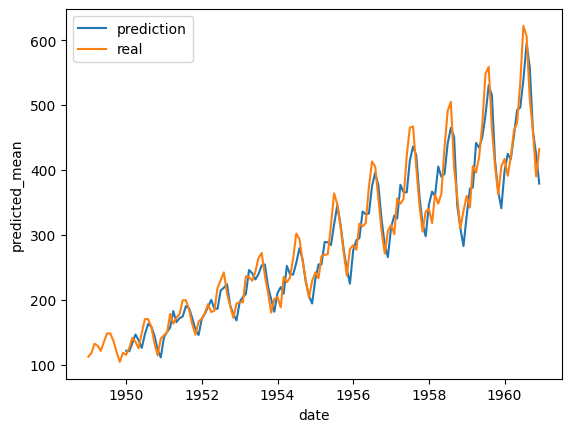

In [76]:
y_hat = ts_arima.predict(12) # argument 1, how many points into the future do you want to predict?
sns.lineplot(y_hat, label='prediction')
sns.lineplot(df['passengers'],label='real')
plt.show()